In [1]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# %matplotlib inline
import pdb

In [2]:
import numpy as np
from config import get_config
import argparse
from Learner import face_learner
from data.data_pipe import get_val_pair
from torchvision import transforms as trans
from tqdm import tqdm_notebook as tqdm


In [3]:
conf = get_config(training=False)
conf.batch_size=200 # Why bs_size can only be the number that divide 6000 well?

In [4]:
learner = face_learner(conf, inference=True)

{'detachAttentionGradient': True, 'fixed_str': 'ir_se50.pth', 'pretrainedMdl': 'ir_se50.pth', 'data_path': PosixPath('data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('work_space/save'), 'exp_title': 'test', 'exp_comment': 'CosFace_ExpMS1M_detached_lre-4', 'input_size': [112, 112], 'embedding_size': 1568, 'use_mobilfacenet': False, 'modelType': 'ArcFace', 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda', index=0), 'test_transform': Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'data_mode': 'emore', 'vgg_folder': PosixPath('data/faces_vgg_112x112'), 'ms1m_folder': PosixPath('data/faces_ms1m_112x112'), 'emore_folder': PosixPath('data/faces_webface_112x112'), 'batch_size': 200, 'USE_SOFTMAX': True, 'SOFTMAX_T': 1, 'facebank_path': PosixPath('data/facebank'), 'threshold': 1.5, 'threshold_xCos': 0.2338, 'face_li

In [5]:
import torch
def getUnitAttention():
    x = torch.ones(conf.batch_size//2, 1, 7, 7).cuda()
    x /= x.flatten(2).sum(dim=2).repeat(1, 1, x.size(2) * x.size(3)).view_as(x)
    return x

def getCorrAttention(corr):
    x = torch.from_numpy(corr).float().cuda()
    print(x.size())
    x = x.unsqueeze(0).unsqueeze(0)
    x = torch.cat(conf.batch_size//2 * [x])
    x /= x.flatten(2).sum(dim=2).repeat(1, 1, x.size(2) * x.size(3)).view_as(x)
    print(x.size())
    return x

unit_attention = getUnitAttention()
unit_attention.size()
# corr_attention = corrUnitAttention()
# corr_attention.size()


torch.Size([100, 1, 7, 7])

In [6]:
test_datasets = ['lfw', 'vgg2_fp', 'agedb_30', 
                 'calfw', 'cfp_ff', 'cfp_fp', 'cplfw']
def testWithDatasets(test_datasets, conf, learner, attention):
    for test_dataset in test_datasets:
        pair_imgs, pair_issame = get_val_pair(conf.emore_folder, test_dataset)
        accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(conf, 
                                                                      pair_imgs, 
                                                                      pair_issame, 
                                                                      nrof_folds=10, 
                                                                      tta=True, 
                                                                      attention=attention)
        print(test_dataset + ' - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
        trans.ToPILImage()(roc_curve_tensor)

In [17]:
# Test patched Cos
exdir = 'test_0906_ir_se50'
print(exdir)
#

test_0906_ir_se50


In [18]:
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)

In [19]:
testWithDatasets(test_datasets, conf, learner, unit_attention)

lfw - accuray:0.9933333333333334, threshold:0.245000000000001
vgg2_fp - accuray:0.9248, threshold:0.17500000000000115
agedb_30 - accuray:0.9265000000000001, threshold:0.21000000000000107
calfw - accuray:0.9288333333333334, threshold:0.23900000000000113
cfp_ff - accuray:0.9834285714285714, threshold:0.2960000000000012
cfp_fp - accuray:0.9095714285714285, threshold:0.18450000000000097
cplfw - accuray:0.8786666666666665, threshold:0.20550000000000096


In [7]:
# Test patched Cos
exdir = 'test_0906_CosFace'
print(exdir)
#

test_0906_CosFace


In [9]:
# mdl_name = '2019-08-25-14-35_accuracy:0.9931666666666666_step:218349_None.pth'
# mdl_name = '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace.pth'
mdl_name = '2019-09-06-08-07_accuracy:0.9970000000000001_step:1601204_CosFace.pth'
learner.load_state(conf, mdl_name, model_only=True, from_save_folder=True, strict=True, model_atten=True)

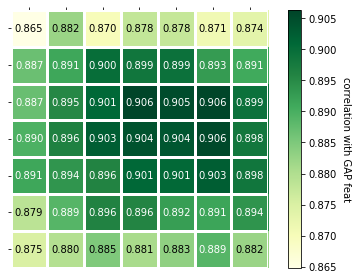

<Figure size 432x288 with 0 Axes>

In [11]:
lfw, lfw_issame = get_val_pair(conf.emore_folder, 'lfw')
corrPlot, corr_eff= learner.plot_CorrBtwPatchCosAndGtCos(conf, 
                                          lfw, lfw_issame, 
                                          nrof_folds=10, tta=True, 
                                          attention=None)
trans.ToPILImage()(corrPlot)
np.save(mdl_name[:-3] + 'npy', corr_eff)

In [12]:
corr_attention = getCorrAttention(corr_eff)
print('>>>>testing unit attention')
testWithDatasets(test_datasets, conf, learner, unit_attention)
print('>>>>testing corr_attention')
testWithDatasets(test_datasets, conf, learner, corr_attention)
print('>>>>testing learned_attention')
testWithDatasets(test_datasets, conf, learner, None)

torch.Size([7, 7])
torch.Size([100, 1, 7, 7])
>>>>testing unit attention
lfw - accuray:0.9968333333333333, threshold:0.19850000000000118
vgg2_fp - accuray:0.9470000000000001, threshold:0.10300000000000087
agedb_30 - accuray:0.9676666666666666, threshold:0.1545000000000011
calfw - accuray:0.9550000000000001, threshold:0.18000000000000105
cfp_ff - accuray:0.9952857142857143, threshold:0.1820000000000011
cfp_fp - accuray:0.9427142857142856, threshold:0.100500000000001
cplfw - accuray:0.9058333333333334, threshold:0.14150000000000099
>>>>testing corr_attention
lfw - accuray:0.9969999999999999, threshold:0.19450000000000106
vgg2_fp - accuray:0.9474, threshold:0.10300000000000087
agedb_30 - accuray:0.9693333333333335, threshold:0.15000000000000102
calfw - accuray:0.9541666666666668, threshold:0.18250000000000097
cfp_ff - accuray:0.995857142857143, threshold:0.183000000000001
cfp_fp - accuray:0.942, threshold:0.10550000000000095
cplfw - accuray:0.9046666666666667, threshold:0.1385000000000010

In [13]:
# Test ArcFace
exdir = 'test_0906_ArcFace'
print(exdir)
#

test_0906_ArcFace


In [14]:
mdl_name = '2019-09-06-06-31_accuracy:0.9963333333333333_step:1018962_ArcFace.pth'
learner.load_state(conf, mdl_name, model_only=True, from_save_folder=True, strict=True, model_atten=True)

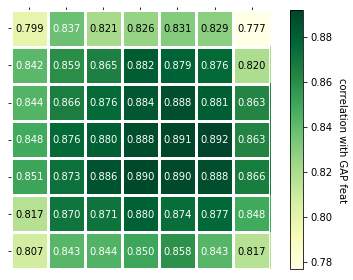

<Figure size 432x288 with 0 Axes>

In [15]:
lfw, lfw_issame = get_val_pair(conf.emore_folder, 'lfw')
corrPlot, corr_eff= learner.plot_CorrBtwPatchCosAndGtCos(conf, 
                                          lfw, lfw_issame, 
                                          nrof_folds=10, tta=True, 
                                          attention=None)
trans.ToPILImage()(corrPlot)
np.save(mdl_name[:-3] + 'npy', corr_eff)


In [16]:
corr_attention = getCorrAttention(corr_eff)
print('>>>>testing unit attention')
testWithDatasets(test_datasets, conf, learner, unit_attention)
print('>>>>testing corr_attention')
testWithDatasets(test_datasets, conf, learner, corr_attention)
print('>>>>testing learned_attention')
testWithDatasets(test_datasets, conf, learner, None)

torch.Size([7, 7])
torch.Size([100, 1, 7, 7])
>>>>testing unit attention
lfw - accuray:0.9953333333333333, threshold:0.22150000000000108
vgg2_fp - accuray:0.9325999999999999, threshold:0.12800000000000095
agedb_30 - accuray:0.9606666666666666, threshold:0.16700000000000098
calfw - accuray:0.9481666666666666, threshold:0.1935000000000011
cfp_ff - accuray:0.9945714285714287, threshold:0.2195000000000012
cfp_fp - accuray:0.9257142857142858, threshold:0.15050000000000102
cplfw - accuray:0.892, threshold:0.16900000000000104
>>>>testing corr_attention
lfw - accuray:0.9955, threshold:0.21700000000000105
vgg2_fp - accuray:0.9316000000000001, threshold:0.12450000000000094
agedb_30 - accuray:0.9615, threshold:0.16600000000000095
calfw - accuray:0.9483333333333333, threshold:0.1910000000000011
cfp_ff - accuray:0.9948571428571429, threshold:0.21800000000000117
cfp_fp - accuray:0.9254285714285715, threshold:0.1535000000000011
cplfw - accuray:0.8931666666666667, threshold:0.16500000000000092
>>>>tes